# Model Evaluation

In this notebook, we will test multiple model and evaluate to choose the best one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [2]:
# Importing data
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
We will split the train data once more. It's because this is a competition dataset and we actually don't have the 'test' score result. So we will use the test set we created from the initial training set as a holdout set to actually see our performance of the final model. The final test set, which we don't have the labels for, will be used to make a prediction in the final testing notebook. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

## Preprocessing
We will be utilizing mostly KNN and tree-based algorithms. We will first turn categorical features to binary dummies.

In [4]:
# Turning all categorical features to dummies 
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [5]:
# Check if training and testing sets have the same features
if X_train.shape[1] != X_test.shape[1]:
    print('only in train:', [x for x in X_train.columns if x not in X_test.columns])
    print('only in test:',[x for x in X_test.columns if x not in X_train.columns])
else: 
    print ('Good to go')

Good to go


In [6]:
# If they are not the same, add the column with 0s and fix the order
# X_test[colname] = 0
# X_test = X_test[X_train.columns]

## Class Imbalance Issue
Our dataset has high class imbalance issue. We will mostly deal with this by setting the class weight within each model, but in some cases where imbalance weight is not adequately dealt with by algorithm we test with resampled set using SMOTE.

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

## Evaluation Metrics
Our target is multi-class with imbalance issue. To focus on the imbalance of minority classes, we will also look at the macro f1 score to capture the predictive performance for overall classes. It calculates the f1 score for each class and find the average so naturally take class imbalance into account.

In [3]:
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, plot_confusion_matrix, classification_report

## Feature Selection
To optimize the process, I will subset features based on a few random decision trees.

In [10]:
original_feats = X_train.columns
len(original_feats)

440

In [4]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [12]:
etc = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state = 23)
etc = etc.fit(X_train, y_train)
model = SelectFromModel(etc, prefit=True, threshold = 1e-4)

In [13]:
X_train_new = model.transform(X_train)
new_feats = original_feats[model.get_support()]

In [14]:
len(new_feats)

395

In [15]:
X_test_new = model.transform(X_test)

In [16]:
X_train = X_train_new
X_test = X_test_new

### Standardization
Since we will be testing kNN, all feature values need to be standardized.

In [5]:
from sklearn.preprocessing import StandardScaler

In [18]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test= scale.transform(X_test)

In [19]:
# Save out train/validation 
mod = open('PKL/new_feats.pkl', 'wb')
pickle.dump(new_feats, mod)
mod.close()

mod = open('PKL/TRAIN_X_train.pkl', 'wb')
pickle.dump(X_train, mod)
mod.close()

mod = open('PKL/TRAIN_X_test.pkl', 'wb')
pickle.dump(X_test, mod)
mod.close()

mod = open('PKL/TRAIN_Y_train.pkl', 'wb')
pickle.dump(y_train, mod)
mod.close()

mod = open('PKL/TRAIN_Y_test.pkl', 'wb')
pickle.dump(y_test, mod)
mod.close()

In [6]:
# reload
new_feats = pickle.load(open('PKL/new_feats.pkl', 'rb'))

X_train = pickle.load(open('PKL/TRAIN_X_train.pkl', 'rb'))
X_test = pickle.load(open('PKL/TRAIN_X_test.pkl', 'rb'))
y_train = pickle.load(open('PKL/TRAIN_Y_train.pkl', 'rb'))
y_test = pickle.load(open('PKL/TRAIN_Y_test.pkl', 'rb'))

## Dummy Classifier
We'll first create a dummy classifier as a baseline score.

In [7]:
scorer = {}

In [8]:
from sklearn.dummy import DummyClassifier

In [9]:
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train, y_train)
y_pred = dummyc.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 3)
f1_test = round(f1_score(y_test, y_pred, average = 'macro'), 3)
ck_test = round(cohen_kappa_score(y_test, y_pred), 3)
print('Accuracy: ', accuracy, 'Test F1 score: ', f1_test, '/ Cohen Kappa: ', ck_test)
scorer['dummy'] = (accuracy, f1_test, ck_test)

Accuracy:  0.332 Test F1 score:  0.295 / Cohen Kappa:  0.001


                         precision    recall  f1-score   support

             functional       0.54      0.33      0.41      4822
functional needs repair       0.07      0.30      0.11       678
         non functional       0.39      0.34      0.36      3410

               accuracy                           0.33      8910
              macro avg       0.33      0.32      0.30      8910
           weighted avg       0.45      0.33      0.37      8910



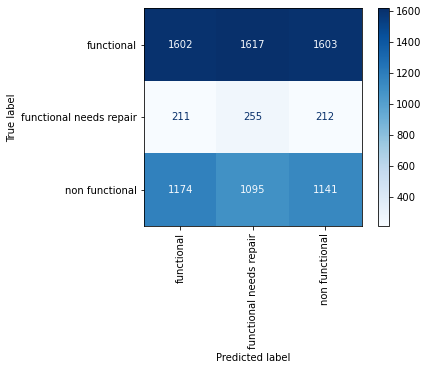

In [10]:
plot_confusion_matrix(dummyc, X_test, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Our stratified dummy classifier shows the weighted F1 score around .45 and less balanced accuracy. Dummy classifier is consistently wrong on all cases but recall for minority classes are especially bad.


## kNearestNeighbors
Now we will run K-Nearest Neighbors using GridSearchCV. 

### Scoring Function
Function to return weighted F1 and balanced accuracy score

In [11]:
def scoring(y_test, y_pred, text, scorer = scorer):
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    f1_test = round(f1_score(y_test, y_pred, average = 'macro'), 3)
    ck_test = round(cohen_kappa_score(y_test, y_pred), 3)
    print('Accuracy: ', accuracy, 'Test F1 score: ', f1_test, '/ Cohen Kappa: ', ck_test)
    scorer[text] = (accuracy, f1_test, ck_test)
    return scorer

### kNN with GridSearchCV

Finding the optimal value for K using GridSearchCV.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [102]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'accuracy', verbose = 1, n_jobs = -1)
knc_g.fit(X_train, y_train)
print(knc_g.best_params_, ': ', knc_g.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 26.2min finished


{'n_neighbors': 3} :  0.8045265348595214


In [103]:
# KNN performance on the test set
y_pred = knc_g.predict(X_test)
scoring(y_test, y_pred, 'knn gridsearch')
print(classification_report(y_test, y_pred))
# Accuracy:  0.745 Test F1 score:  0.633 / Cohen Kappa:  0.541
# Recall for functional needs repair: 0.36

Accuracy:  0.745 Test F1 score:  0.633 / Cohen Kappa:  0.541
                         precision    recall  f1-score   support

             functional       0.80      0.79      0.80      4822
functional needs repair       0.35      0.36      0.35       678
         non functional       0.75      0.75      0.75      3410

               accuracy                           0.75      8910
              macro avg       0.63      0.63      0.63      8910
           weighted avg       0.75      0.75      0.75      8910



In [104]:
# saving the model 
mod = open('PKL/knn_gsc.pkl', 'wb')
pickle.dump(knc_g.best_estimator_, mod)
mod.close()

In [15]:
# Reload the model
#knc_g = pickle.load(open('PKL/knn_g.pkl', 'rb'))

### kNN with Optuna
Now we want to try different optimization method to make sure we have the best hyperparmeter for KNN. This time we'll use optuna to explore even more hyperparameters. We'll cap the time to what it took to be same as the time it took to complete GridSearch above.

In [16]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [27]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    #leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             #leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1))
    return (score)

# initiating the optuna study
knn_study = optuna.create_study(direction='maximize')

# optimization process
knn_study.optimize(find_hyperp_KNN, n_trials=50)

[I 2020-08-31 10:47:30,414] Trial 0 finished with value: 0.8161463753035033 and parameters: {'n_neighbors': 4, 'algorithm': 'ball_tree', 'p': 2}. Best is trial 0 with value: 0.8161463753035033.
[I 2020-08-31 10:56:01,783] Trial 1 finished with value: 0.8082032604925425 and parameters: {'n_neighbors': 30, 'algorithm': 'ball_tree', 'p': 1}. Best is trial 0 with value: 0.8161463753035033.
[I 2020-08-31 11:04:32,451] Trial 2 finished with value: 0.8183836281651058 and parameters: {'n_neighbors': 13, 'algorithm': 'ball_tree', 'p': 1}. Best is trial 2 with value: 0.8183836281651058.
[I 2020-08-31 11:12:59,769] Trial 3 finished with value: 0.8180367672563301 and parameters: {'n_neighbors': 14, 'algorithm': 'ball_tree', 'p': 1}. Best is trial 2 with value: 0.8183836281651058.
[I 2020-08-31 11:21:27,227] Trial 4 finished with value: 0.8090010405827263 and parameters: {'n_neighbors': 28, 'algorithm': 'ball_tree', 'p': 1}. Best is trial 2 with value: 0.8183836281651058.
[I 2020-08-31 11:29:56,831

[I 2020-08-31 14:15:11,023] Trial 42 finished with value: 0.824262920568852 and parameters: {'n_neighbors': 4, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 23 with value: 0.824262920568852.
[I 2020-08-31 14:18:32,172] Trial 43 finished with value: 0.8210197710718002 and parameters: {'n_neighbors': 2, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 23 with value: 0.824262920568852.
[I 2020-08-31 14:22:25,111] Trial 44 finished with value: 0.8228061047519943 and parameters: {'n_neighbors': 5, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 23 with value: 0.824262920568852.
[I 2020-08-31 14:26:40,408] Trial 45 finished with value: 0.8219562955254943 and parameters: {'n_neighbors': 8, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 23 with value: 0.824262920568852.
[I 2020-08-31 14:31:03,708] Trial 46 finished with value: 0.8207422823447796 and parameters: {'n_neighbors': 10, 'algorithm': 'kd_tree', 'p': 1}. Best is trial 23 with value: 0.824262920568852.
[I 2020-08-31 14:39:12,265] Trial 4

In [28]:
# saving the study 
mod = open('PKL/knn_study.pkl', 'wb')
pickle.dump(knn_study, mod)
mod.close()

In [17]:
# Reload the study
knn_study = pickle.load(open('PKL/knn_study.pkl', 'rb'))

In [29]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(**knn_study.best_params, weights = 'distance', n_jobs = -1)
knc_opt.fit(X_train, y_train)

y_pred = knc_opt.predict(X_test)
scoring(y_test, y_pred, 'knn optuna')
print(classification_report(y_test, y_pred))
# Accuracy:  0.754 Test F1 score:  0.644 / Cohen Kappa:  0.556
# functional needs repair recall = 0.37

Accuracy:  0.754 Test F1 score:  0.644 / Cohen Kappa:  0.556
                         precision    recall  f1-score   support

             functional       0.80      0.80      0.80      4822
functional needs repair       0.36      0.37      0.37       678
         non functional       0.77      0.76      0.76      3410

               accuracy                           0.75      8910
              macro avg       0.64      0.64      0.64      8910
           weighted avg       0.75      0.75      0.75      8910



Recall score for the needs repair class is still low but the overall performance and the recall for non-functional improved slightly.

In [30]:
# saving the model
mod = open('PKL/knc_opt_model.pkl', 'wb')
pickle.dump(knc_opt, mod)
mod.close()

In [18]:
knc_study = pickle.load(open('PKL/knc_opt_model.pkl', 'rb'))

## Random Forest 
We will run random forest optimized by Optuna.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 700)
    #max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, X_train.shape[1])
    min_weight_fraction_leaf = trial.suggest_loguniform('min_weight_fraction_leaf', 1e-7, 0.1)
    max_leaf_nodes= trial.suggest_int('max_leaf_nodes', 10, 200)
    rfc = RandomForestClassifier(oob_score = True, 
                                 n_estimators = n_estimators,
                                 #max_depth = max_depth, 
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 criterion = criterion,
                                 class_weight = class_weight, 
                                 max_features = max_features,
                                 min_weight_fraction_leaf=min_weight_fraction_leaf,
                                 max_leaf_nodes = max_leaf_nodes
                                )
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train, y_train,
                                    scoring = 'accuracy', cv = cv, n_jobs = -1))
    return (score)

#rfc_study = optuna.create_study(direction='maximize')
rfc_study.optimize(find_hyperparam_rf, n_trials = 150)

[I 2020-08-31 15:19:45,141] Trial 2 finished with value: 0.7546999653139091 and parameters: {'n_estimators': 157, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 140, 'min_weight_fraction_leaf': 0.002360813755796459, 'max_leaf_nodes': 143}. Best is trial 2 with value: 0.7546999653139091.
[I 2020-08-31 15:21:30,915] Trial 3 finished with value: 0.7416579951439474 and parameters: {'n_estimators': 236, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 36, 'min_weight_fraction_leaf': 5.857245209987763e-07, 'max_leaf_nodes': 96}. Best is trial 2 with value: 0.7546999653139091.
[I 2020-08-31 15:24:16,631] Trial 4 finished with value: 0.7600936524453694 and parameters: {'n_estimators': 684, 'min_samples_split': 10, 'min_samples_leaf': 10, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 13, 'min_weight_fraction_leaf': 2.99058839384379

[I 2020-08-31 19:24:20,757] Trial 24 finished with value: 0.7767429760665973 and parameters: {'n_estimators': 286, 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 236, 'min_weight_fraction_leaf': 4.630284990635767e-05, 'max_leaf_nodes': 198}. Best is trial 14 with value: 0.780454387790496.
[I 2020-08-31 19:32:45,885] Trial 25 finished with value: 0.7781997918834547 and parameters: {'n_estimators': 389, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 124, 'min_weight_fraction_leaf': 0.0005002453255510903, 'max_leaf_nodes': 186}. Best is trial 14 with value: 0.780454387790496.
[I 2020-08-31 19:49:30,078] Trial 26 finished with value: 0.7402011793270898 and parameters: {'n_estimators': 541, 'min_samples_split': 5, 'min_samples_leaf': 4, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 188, 'min_weight_fraction_leaf': 

[I 2020-08-31 23:17:33,909] Trial 46 finished with value: 0.7606486298994103 and parameters: {'n_estimators': 424, 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 197, 'min_weight_fraction_leaf': 0.00203067672140001, 'max_leaf_nodes': 165}. Best is trial 30 with value: 0.7815816857440167.
[I 2020-08-31 23:33:30,099] Trial 47 finished with value: 0.773309053069719 and parameters: {'n_estimators': 373, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 264, 'min_weight_fraction_leaf': 0.0007392806811034481, 'max_leaf_nodes': 191}. Best is trial 30 with value: 0.7815816857440167.
[I 2020-08-31 23:40:51,094] Trial 48 finished with value: 0.7798300381547001 and parameters: {'n_estimators': 255, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 175, 'min_weight_fraction_leaf': 2.095544

[I 2020-09-01 02:58:54,034] Trial 68 finished with value: 0.7783732223378426 and parameters: {'n_estimators': 551, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 137, 'min_weight_fraction_leaf': 7.064460583097715e-05, 'max_leaf_nodes': 184}. Best is trial 57 with value: 0.7816163718348943.
[I 2020-09-01 03:11:05,325] Trial 69 finished with value: 0.7805237599722512 and parameters: {'n_estimators': 595, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 121, 'min_weight_fraction_leaf': 1.0586925446678983e-05, 'max_leaf_nodes': 192}. Best is trial 57 with value: 0.7816163718348943.
[I 2020-09-01 03:23:33,270] Trial 70 finished with value: 0.7427332639611516 and parameters: {'n_estimators': 674, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 119, 'min_weight_fraction_leaf': 8.061011638987081e-06, 'max

[I 2020-09-01 07:33:25,087] Trial 91 finished with value: 0.7816510579257716 and parameters: {'n_estimators': 511, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 115, 'min_weight_fraction_leaf': 2.36142629553801e-07, 'max_leaf_nodes': 200}. Best is trial 91 with value: 0.7816510579257716.
[I 2020-09-01 07:43:07,216] Trial 92 finished with value: 0.7811307665626084 and parameters: {'n_estimators': 494, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 117, 'min_weight_fraction_leaf': 1.866142752354367e-07, 'max_leaf_nodes': 196}. Best is trial 91 with value: 0.7816510579257716.
[I 2020-09-01 07:51:27,265] Trial 93 finished with value: 0.7799514394727715 and parameters: {'n_estimators': 491, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 97, 'min_weight_fraction_leaf': 1.9151204537137612e-07, 'max_l

[I 2020-09-01 11:27:55,910] Trial 113 finished with value: 0.780610475199445 and parameters: {'n_estimators': 547, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 139, 'min_weight_fraction_leaf': 3.4992191151622687e-07, 'max_leaf_nodes': 197}. Best is trial 105 with value: 0.7818244883801595.
[I 2020-09-01 11:35:52,748] Trial 114 finished with value: 0.7813562261533125 and parameters: {'n_estimators': 446, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 103, 'min_weight_fraction_leaf': 1.6445499380069564e-07, 'max_leaf_nodes': 199}. Best is trial 105 with value: 0.7818244883801595.
[I 2020-09-01 11:43:00,802] Trial 115 finished with value: 0.7793444328824142 and parameters: {'n_estimators': 451, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 86, 'min_weight_fraction_leaf': 1.949606033853469e-07, 

[I 2020-09-01 15:02:36,579] Trial 135 finished with value: 0.7813388831078738 and parameters: {'n_estimators': 503, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 134, 'min_weight_fraction_leaf': 4.998202388057768e-07, 'max_leaf_nodes': 200}. Best is trial 105 with value: 0.7818244883801595.
[I 2020-09-01 15:11:27,719] Trial 136 finished with value: 0.7803676725633021 and parameters: {'n_estimators': 501, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 101, 'min_weight_fraction_leaf': 5.141542246408138e-07, 'max_leaf_nodes': 194}. Best is trial 105 with value: 0.7818244883801595.
[I 2020-09-01 15:27:56,333] Trial 137 finished with value: 0.7790842872008326 and parameters: {'n_estimators': 520, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 182, 'min_weight_fraction_leaf': 1.0994821429323673e-06,

KeyboardInterrupt: 

In [35]:
rf = RandomForestClassifier(oob_score = True, **rfc_study.best_params, n_jobs = -1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
scoring(y_test, y_pred_rf, 'random forest optuna')
print(classification_report(y_test, y_pred_rf))
#Accuracy:  0.745 Test F1 score:  0.648 / Cohen Kappa:  0.541
# functional needs repair recall = 0.46

Accuracy:  0.745 Test F1 score:  0.648 / Cohen Kappa:  0.541
                         precision    recall  f1-score   support

             functional       0.77      0.84      0.80      4822
functional needs repair       0.35      0.46      0.40       678
         non functional       0.83      0.67      0.74      3410

               accuracy                           0.75      8910
              macro avg       0.65      0.66      0.65      8910
           weighted avg       0.76      0.75      0.75      8910



Much better performance in predicting the positive minority cases even though overall F1 score has dropped slightly. This model seems to be weighing the minority recall better. 

In [34]:
# save the study
mod = open('PKL/rfc_study.pkl', 'wb')
pickle.dump(rfc_study, mod)
mod.close()

In [20]:
# Reload the study
rfc_study = pickle.load(open('PKL/rfc_study.pkl', 'rb'))

In [36]:
# save the model
mod = open('PKL/rf_model.pkl', 'wb')
pickle.dump(rf, mod)
mod.close()

In [21]:
rf_model = pickle.load(open('PKL/rf_model.pkl', 'rb'))

In [37]:
# feature importance
rf_feats = pd.DataFrame(rf.feature_importances_,
                        index = new_feats,
                        columns=['feat_importance']).sort_values('feat_importance',ascending=False)
rf_feats.head(10)

,feat_importance
quantity_dry,0.1482
quantity_enough,0.0502
extraction_type_c_other,0.0500
longitude,0.0418
waterpoint_type_hand pump,0.0358
quantity_insufficient,0.0337
waterpoint_type_other,0.0327
lga_bariadi,0.0308
year_built_after05,0.0295
lga_long,0.0290


In [38]:
rf_feats.tail(10)

,feat_importance
funder_jica,0.0
funder_ded,0.0
funder_jaica,0.0
installer_rwssp,0.0
installer_ir,0.0
funder_ir,0.0
source_unknown,0.0
installer_is,0.0
installer_jaica,0.0
extraction_type_c_windmill,0.0


## XGBoost
Now we'll try to run XGBoost with Optuna.

In [22]:
import xgboost as xgb

In [40]:
def find_hyperparam(trial):
    eta = trial.suggest_loguniform('eta', 0.001, 1)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    #min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform('subsample', 0.4, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform('colsample_bytree', 0.01, 1.0)
    colsample_bylevel = trial.suggest_loguniform('colsample_bylevel', 0.01, 1.0)
    colsample_bynode = trial.suggest_loguniform('colsample_bynode', 0.01, 1.0)

    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             max_depth = max_depth, 
                             #min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             #sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                             colsample_bynode = colsample_bynode, 
                             colsample_bylevel = colsample_bylevel)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train, y_train, 
                                    scoring = 'accuracy', cv = cv, 
                                    n_jobs = -1))
    return (score)

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(find_hyperparam, timeout = 60*60)

[I 2020-09-01 15:55:40,778] Trial 0 finished with value: 0.6527922303156435 and parameters: {'eta': 0.16874718766825794, 'max_depth': 9, 'subsample': 0.7527545370965828, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.012929896348276982, 'colsample_bylevel': 0.10019852848838491, 'colsample_bynode': 0.3051975466289551}. Best is trial 0 with value: 0.6527922303156435.
[I 2020-09-01 15:56:22,383] Trial 1 finished with value: 0.7097641345820326 and parameters: {'eta': 0.002336339825524799, 'max_depth': 26, 'subsample': 0.44979595308116943, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.5828607244928107, 'colsample_bylevel': 0.6779726402617559, 'colsample_bynode': 0.02258704899368756}. Best is trial 1 with value: 0.7097641345820326.
[I 2020-09-01 15:56:45,382] Trial 2 finished with value: 0.5746791536593826 and parameters: {'eta': 0.013090425960925883, 'max_depth': 1, 'subsample': 0.5644791653429895, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.024573303

[I 2020-09-01 16:05:33,092] Trial 21 finished with value: 0.7737599722511274 and parameters: {'eta': 0.9004018249773049, 'max_depth': 45, 'subsample': 0.9945219060534617, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.9904454401593182, 'colsample_bylevel': 0.010548271079508223, 'colsample_bynode': 0.04282258173248781}. Best is trial 17 with value: 0.7804717308359347.
[I 2020-09-01 16:06:02,382] Trial 22 finished with value: 0.7608740894901145 and parameters: {'eta': 0.5437754937868607, 'max_depth': 44, 'subsample': 0.8190509284824469, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.6203037366988315, 'colsample_bylevel': 0.018226322324226055, 'colsample_bynode': 0.04329195373252251}. Best is trial 17 with value: 0.7804717308359347.
[I 2020-09-01 16:06:30,747] Trial 23 finished with value: 0.7703780783905654 and parameters: {'eta': 0.972531910125017, 'max_depth': 33, 'subsample': 0.9475176565115101, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.3602916

[I 2020-09-01 16:15:26,794] Trial 42 finished with value: 0.7676378772112382 and parameters: {'eta': 0.6321157383895158, 'max_depth': 46, 'subsample': 0.9022200191242498, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.990018152133977, 'colsample_bylevel': 0.010062605202291422, 'colsample_bynode': 0.03174221744781355}. Best is trial 17 with value: 0.7804717308359347.
[I 2020-09-01 16:15:56,282] Trial 43 finished with value: 0.7694935830731877 and parameters: {'eta': 0.9638597463142387, 'max_depth': 50, 'subsample': 0.7872179587152606, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.979479649672917, 'colsample_bylevel': 0.018906878025572758, 'colsample_bynode': 0.023264913810973703}. Best is trial 17 with value: 0.7804717308359347.
[I 2020-09-01 16:16:25,376] Trial 44 finished with value: 0.7757544224765869 and parameters: {'eta': 0.9497532389786201, 'max_depth': 39, 'subsample': 0.85142392275818, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.724717048

[I 2020-09-01 16:27:28,941] Trial 63 finished with value: 0.8191467221644121 and parameters: {'eta': 0.07634308873843847, 'max_depth': 43, 'subsample': 0.4240694791335665, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.5197804736883753, 'colsample_bylevel': 0.46363100304232086, 'colsample_bynode': 0.0758509831427972}. Best is trial 62 with value: 0.8298820672910162.
[I 2020-09-01 16:28:37,644] Trial 64 finished with value: 0.8242976066597294 and parameters: {'eta': 0.06720881937183196, 'max_depth': 42, 'subsample': 0.4759015981677102, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.542843569624773, 'colsample_bylevel': 0.5210140938077948, 'colsample_bynode': 0.073398315128739}. Best is trial 62 with value: 0.8298820672910162.
[I 2020-09-01 16:29:30,627] Trial 65 finished with value: 0.7937044745057232 and parameters: {'eta': 0.06709931789052281, 'max_depth': 43, 'subsample': 0.4218151951710794, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.3247152901

In [41]:
#Saving study
mod = open('PKL/xgb_study.pkl', 'wb')
pickle.dump(xgb_study, mod)
mod.close()

In [23]:
# Reload the study
xgb_study = pickle.load(open('PKL/xgb_study.pkl', 'rb'))

In [24]:
xgb_study.best_params

{'eta': 0.047015847004812955,
 'max_depth': 36,
 'subsample': 0.4778081513429783,
 'sampling_method': 'gradient_based',
 'colsample_bytree': 0.415717416280942,
 'colsample_bylevel': 0.9884376260231053,
 'colsample_bynode': 0.20250017161748426}

In [27]:
best_ = xgb_study.best_params

In [28]:
best_['sampling_method'] = 'uniform'

In [29]:
# fitting and testing on the test set

xgbc = xgb.XGBClassifier(**best_, verbosity=1)

xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)    
scoring(y_test, y_pred, 'xgboost')
print(classification_report(y_test, y_pred))

# Accuracy:  0.792 Test F1 score:  0.69 / Cohen Kappa:  0.624
# functional needs repair recall = 0.44

Accuracy:  0.792 Test F1 score:  0.69 / Cohen Kappa:  0.624
                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      4822
functional needs repair       0.43      0.44      0.43       678
         non functional       0.83      0.79      0.81      3410

               accuracy                           0.79      8910
              macro avg       0.69      0.69      0.69      8910
           weighted avg       0.79      0.79      0.79      8910



Top majority classes are doing so much better, but the minority class recall score dropped significantly from random forest model. We'll try to oversampling the minority classes and try again.

In [30]:
# saving model
mod = open('PKL/xgbc_model.pkl', 'wb')
pickle.dump(xgbc, mod)
mod.close()

In [ ]:
#xgbc_model = pickle.load(open('PKL/xgbc_model.pkl', 'rb'))

## Voting Classifier
Now I will try to run a voting classifier using some of the above models. Since many of the models did better with with minority classes oversampled, I will use oversampled data for voting.

In [34]:
from sklearn.ensemble import VotingClassifier

voting_c_soft = VotingClassifier(estimators = [
                                          ('knc_study', knc_study),
                                          ('rf_model', rf_model),
                                          ('xgbc', xgbc)
                                         ], 
                            voting = 'soft', 
                           n_jobs = -1)
voting_c_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('knc_study',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_jobs=-1, n_neighbors=4,
                                                   p=1, weights='distance')),
                             ('rf_model',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features=135,
                                                     max_leaf_nodes=200,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     min_weight_fraction_leaf=2.2193985313288622e-07,
                                                     n_estimators=466,
                                                     n_jobs=-1,
                                                     oob_score...
                

In [35]:
y_pred = voting_c_soft.predict(X_test)    
scoring(y_test, y_pred, 'voting')
print(classification_report(y_test, y_pred))

#Accuracy:  0.789 Test F1 score:  0.685 / Cohen Kappa:  0.619
# functional needs repair recall = 0.42

Accuracy:  0.789 Test F1 score:  0.685 / Cohen Kappa:  0.619
                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      4822
functional needs repair       0.42      0.42      0.42       678
         non functional       0.82      0.79      0.80      3410

               accuracy                           0.79      8910
              macro avg       0.69      0.68      0.69      8910
           weighted avg       0.79      0.79      0.79      8910



In [36]:
# save model
mod = open('PKL/voting_c_soft.pkl', 'wb')
pickle.dump(voting_c_soft, mod)
mod.close()

In [ ]:
# Reload the model
#voting_c_soft = pickle.load(open('PKL/voting_c_soft.pkl', 'rb'))

### Hard voting

In [37]:
voting_c_hard = VotingClassifier(estimators = [
                                          ('knc_study', knc_study),
                                          ('rf_model', rf_model),
                                          ('xgbc', xgbc)
                                         ], 
                            voting = 'hard', 
                           n_jobs = -1)
voting_c_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('knc_study',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_jobs=-1, n_neighbors=4,
                                                   p=1, weights='distance')),
                             ('rf_model',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features=135,
                                                     max_leaf_nodes=200,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     min_weight_fraction_leaf=2.2193985313288622e-07,
                                                     n_estimators=466,
                                                     n_jobs=-1,
                                                     oob_score...
                

In [38]:
y_pred = voting_c_hard.predict(X_test)    
scoring(y_test, y_pred, 'voting')
print(classification_report(y_test, y_pred))

# Test F1 score:  0.77 / Test Accuracy:  0.671
# functional needs repair recall = 0.43

Accuracy:  0.789 Test F1 score:  0.686 / Cohen Kappa:  0.617
                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      4822
functional needs repair       0.42      0.42      0.42       678
         non functional       0.84      0.77      0.80      3410

               accuracy                           0.79      8910
              macro avg       0.69      0.68      0.69      8910
           weighted avg       0.79      0.79      0.79      8910



In [91]:
# save model
mod = open('PKL/voting_c_hard.pkl', 'wb')
pickle.dump(voting_c_hard, mod)
mod.close()

In [ ]:
# Reload the model
#voting_c_hard = pickle.load(open('PKL/voting_c_hard.pkl', 'rb'))

In [97]:
from sklearn.linear_model import SGDClassifier

In [107]:
SGDC = SGDClassifier(loss = 'log', penalty='elasticnet', 
                     max_iter=1000, tol=1e-3)
SGDC.fit(X_train, y_train)
y_pred = SGDC.predict(X_test)
scoring(y_test, y_pred, 'SGDC')


Accuracy:  0.721 Test F1 score:  0.609 / Cohen Kappa:  0.5


{'dummy': (0.33, 0.294, -0.006),
 'knn optuna': (0.752, 0.641, 0.553),
 'random forest optuna': (0.739, 0.64, 0.528),
 'xgboost': (0.776, 0.679, 0.595),
 'voting': (0.789, 0.688, 0.618),
 'SGDC': (0.721, 0.609, 0.5)}

In [111]:
feat_importance = pd.DataFrame(SGDC.coef_.T, columns = SGDC.classes_, index = new_feats)

In [118]:
feat_importance.sort_values(by = 'functional needs repair', ascending = False).head(10)

,functional,functional needs repair,non functional
zero_gps_height,-0.1149,0.7935,-0.5102
extraction_type_c_gravity,1.1832,0.7132,-0.5590
region_kigoma,-0.1515,0.4531,-0.1545
region_singida,0.2190,0.4333,-0.8397
gps_height,0.0000,0.4161,-0.2863
region_morogoro,0.4695,0.4074,-0.3351
district_code_1,0.3417,0.3743,-0.3276
lga_bukombe,-0.0472,0.3176,-0.1185
lga_bariadi,0.0000,0.2991,0.0000
extraction_type_c_submersible,0.6848,0.2924,-0.3025
